# Familiarizing my self with audio data

In [1]:
import numpy as np
import pandas as pd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import sklearn
import tqdm
import json

In [2]:
with open('nsynth-test/examples.json', 'r') as f:
    meta = json.load(f)

In [3]:
# Inspect the metadata keys
first_key = list(meta.keys())[0]
print(meta[first_key])

{'qualities': [0, 1, 0, 0, 0, 0, 0, 0, 0, 0], 'pitch': 49, 'note': 217499, 'instrument_source_str': 'synthetic', 'velocity': 25, 'instrument_str': 'bass_synthetic_068', 'instrument': 656, 'sample_rate': 16000, 'qualities_str': ['dark'], 'instrument_source': 2, 'note_str': 'bass_synthetic_068-049-025', 'instrument_family': 0, 'instrument_family_str': 'bass'}


In [4]:
#Filter to reed audio, because that's my primary instrument
reed_files = [fname for fname, info in meta.items() if info['instrument_family_str'] == 'reed']
print(f"Found {len(reed_files)} reed samples.")

Found 235 reed samples.


In [5]:
reed_files[0]

'reed_acoustic_037-068-127'

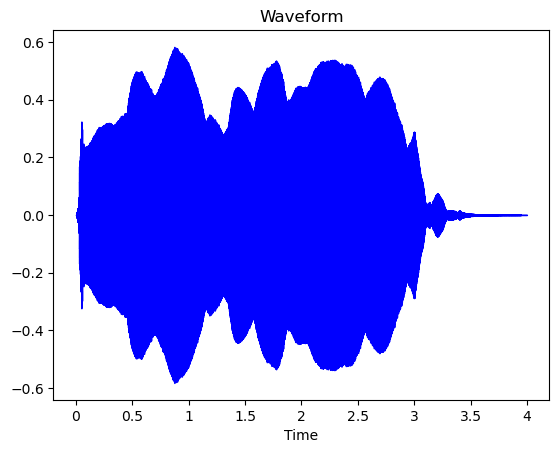

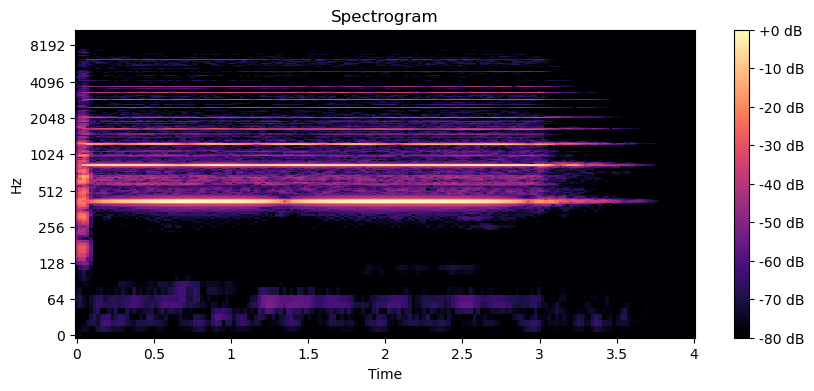

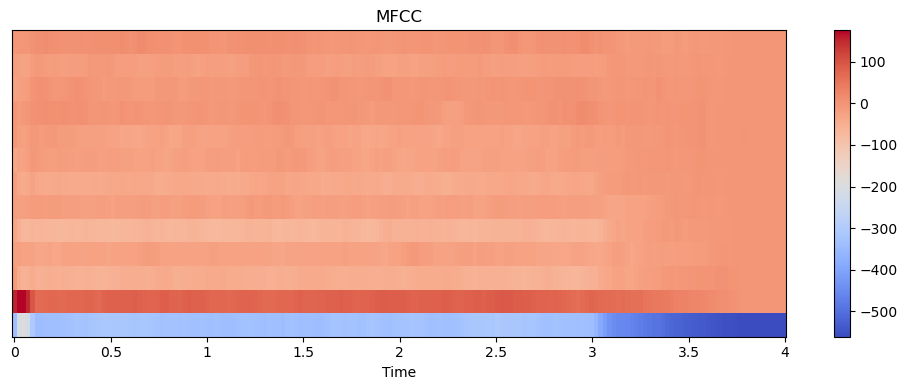

In [7]:
# Load an example of sound file
sample_file = 'nsynth-test/audio/' + reed_files[0] +'.wav' # update for your local folder
y, sr = librosa.load(sample_file)

#Plot the waveform
fig,ax = plt.subplots()
librosa.display.waveshow(y, sr=sr,ax=ax,color='blue')
ax.set_title('Waveform')
plt.show()

#Show the spectogram over time
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.show()

#Show a mfcc matrix
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
librosa.display.specshow(mfcc, x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [9]:
# Extract features for all the reed samples
X, y = [], []
for fname in tqdm.tqdm(reed_files):
    path = 'nsynth-test/audio/' + fname + '.wav'
    y_audio, sr = librosa.load(path)
    mfcc = librosa.feature.mfcc(y=y_audio, sr=sr, n_mfcc=13)
    X.append(mfcc.mean(axis=1))
    label = meta[fname]['pitch']    # MIDI number (e.g., 60 = C4)
    y.append(label)

X = pd.DataFrame(X, columns=[f'MFCC{i}' for i in range(1,14)])
y = pd.Series(y, name='pitch')
df = pd.concat([X, y], axis=1)
df.to_csv('reed_mfcc_features.csv', index=False)

100%|██████████| 235/235 [00:02<00:00, 107.67it/s]


# Learning some features

In [2]:
#Load data from the previous extranxted csv file.
df = pd.read_csv('reed_mfcc_features.csv')

## Train/Test split

In [8]:
X = df.drop('pitch',axis=1).values  #Hide values we want to infer
y = df['pitch'].values #Learning the pitch
X_train,X_test,y_train,y_test = sklearn.model_selection.train_test_split(X, y, test_size=0.2, random_state=42, stratify = None) #Don't do stratification on such a low sample

## Train a classifier

In [9]:
clf = sklearn.ensemble.RandomForestClassifier(n_estimators=100,random_state=42)
clf.fit(X_train,y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


# Evaluation of the model

In [11]:
y_pred = clf.predict(X_test)
print("Test accuracy : ", sklearn.metrics.accuracy_score(y_test,y_pred))

Test accuracy :  0.3617021276595745


/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")


In [12]:
import seaborn as sns

/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:98: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_true = type_of_target(y_true, input_name="y_true")
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/metrics/_classification.py:99: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  type_pred = type_of_target(y_pred, input_name="y_pred")
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  ys_types = set(type_of_target(x) for x in ys)
/share/pkg.8/academic-ml/fall-2025/install/fall-2025-tf/lib/python3.12/site-packages/sklearn/utils/multiclass.py:79: UserWarning: The number of unique classes is greater than 50% of the number of samples.
  

Text(0.5, 1.0, 'Confusion Matrix')

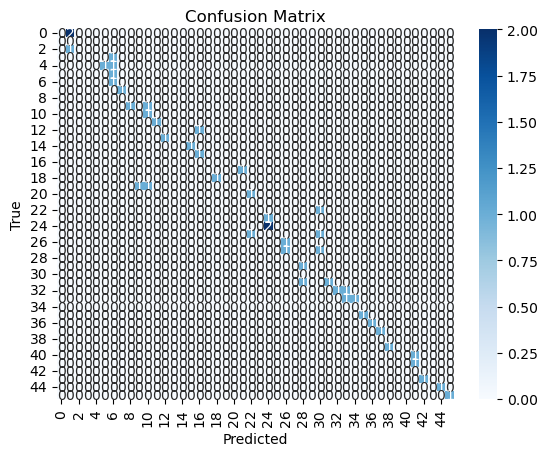

In [13]:
cm = sklearn.metrics.confusion_matrix(y_test,y_pred)
fig,ax=plt.subplots()
sns.heatmap(cm,annot=True,fmt='d',cmap='Blues',ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title('Confusion Matrix')

Obviously the model is doing very poorly with such a small amount of data, and should be trained on a much larger dataset. We can first look at what happens when we include other instruments, i.e the entire test set from nsynth.